In [1]:
import torch

import cutlass

import cutlass_emit_pytorch_mocked

In [3]:
import cutlass

USE_EFFICIENT_ALLOCATION = True

def group_gemm_jit(As, Bs):
    dtype = As[0].dtype
    plan = cutlass.op.GroupedGemm(element=dtype, element_accumulator=torch.float32, layout=cutlass.LayoutType.RowMajor)

    Cs = [torch.zeros(a.shape[:-1] + (b.shape[-1],), dtype=a.dtype, device=a.device) for a,b in zip(As, Bs)]
    Ds = [torch.zeros_like(el) for el in Cs]
    
    plan.run(As, Bs, Cs, Ds, print_module=True)
    op = plan.construct()

    if USE_EFFICIENT_ALLOCATION:
        import cutlass_emit_pytorch_mocked
        grouped_gemm = cutlass_emit_pytorch_mocked.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)
    else:
        grouped_gemm = cutlass.emit.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)

    return grouped_gemm


In [4]:
b_shape = (2048, 2048)
a_shape = (1, 2048*16, 2048)

# 2048*1, 2048*4, 2048*16, 2048*64

segment_size = 128 # a_shape[1]
dtype = torch.float16

a = torch.randn(a_shape, dtype=dtype, device='cuda')
b = torch.randn(b_shape, dtype=dtype, device='cuda')

a_segments = torch.split(a, segment_size, dim=1)
b_list = [b]*len(a_segments)


In [5]:
len(a_segments)

256

In [6]:
gemm_jited = group_gemm_jit(a_segments, b_list);


// Gemm operator cutlass_tensorop_f16_s16816gemm_grouped_f16_256x128_64x3_tt_align8
using cutlass_tensorop_f16_s16816gemm_grouped_f16_256x128_64x3_tt_align8_base =
  typename cutlass::gemm::kernel::DefaultGemmGrouped<
    cutlass::half_t, cutlass::layout::RowMajor, cutlass::ComplexTransform::kNone, 8,
    cutlass::half_t, cutlass::layout::RowMajor, cutlass::ComplexTransform::kNone, 8,
    cutlass::half_t, cutlass::layout::RowMajor,
    float,
    cutlass::arch::OpClassTensorOp,
    cutlass::arch::Sm80,
    cutlass::gemm::GemmShape<256, 128, 64>,
    cutlass::gemm::GemmShape<64, 64, 64>,
    cutlass::gemm::GemmShape<16, 8, 16>,
    cutlass::epilogue::thread::LinearCombination<cutlass::half_t, 8, float, float>,
    cutlass::gemm::threadblock::GemmIdentityThreadblockSwizzle<1>,
    3,
    cutlass::gemm::kernel::GroupScheduleMode::kDeviceOnly,
    cutlass::arch::OpMultiplyAdd
>::GemmKernel;

// Define named type
struct cutlass_tensorop_f16_s16816gemm_grouped_f16_256x128_64x3_tt_align8_typ

In [238]:
# %%timeit

# c_torch = a @ b

# torch.cuda.synchronize();

In [8]:
%%timeit

c_grouped = gemm_jited.run(a_segments, b_list)

torch.cuda.synchronize();

947 μs ± 818 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
1,47

## Plot results

In [10]:
# Compare torch batched matmul to cutlass grouped
# Ideally should be equal, in reality - we drop because of implementation

# Sequence lengths
seq_lengths = [2048, 8192, 32768, 131072]

# Torch batched matmul results
torch_batched_results = [0.1, 0.306, 1.13, 4.45]

# Cutlass grouped matmul results
cutlass_grouped_results_32 = [0.394, 1.46, 5.69, 22.3]
cutlass_grouped_results_128 = [0.145, 0.419, 1.52, 6.02]
cutlass_grouped_results_256 = [0.109, 0.254, 0.855, 3.3]
cutlass_grouped_results_512 = [0.084, 0.178, 0.518, 1.96]

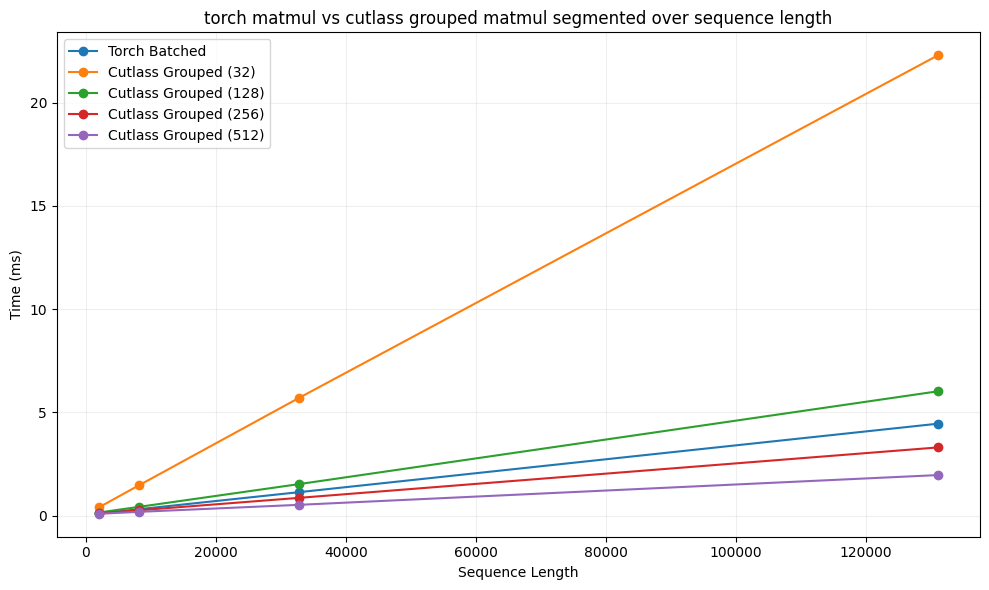

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, torch_batched_results, 'o-', label='Torch Batched')
plt.plot(seq_lengths, cutlass_grouped_results_32, 'o-', label='Cutlass Grouped (32)')
plt.plot(seq_lengths, cutlass_grouped_results_128, 'o-', label='Cutlass Grouped (128)')
plt.plot(seq_lengths, cutlass_grouped_results_256, 'o-', label='Cutlass Grouped (256)')
plt.plot(seq_lengths, cutlass_grouped_results_512, 'o-', label='Cutlass Grouped (512)')

# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Sequence Length')
plt.ylabel('Time (ms)')
plt.title('torch matmul vs cutlass grouped matmul segmented over sequence length')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.savefig("/home/jovyan/sivtsov/armt/graphs/matmul_comparison.pdf", bbox_inches='tight')
plt.show()
